# I’m Something of a Painter Myself - Creating art with GANs

This notebook explores the application of GANs using the dataset from Jang, Uzsoy, and Culliton (2020). It closely follows the tutorial by Jang (2020) to train a generative adversarial network for transforming photos into Monet-ized paintings. The goal of this project is to learn about GANs and how to apply them practically.

# Exploratory Data Analysis (EDA)

The first step is to import TensorFlow and set the path to the images. We will use the TFRecords files to read the TFRecords (used by Tensorflow).

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

MONET_TFREC_PATH = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
PHOTO_TFREC_PATH = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

Here, we will set the size to 256x256 (as guided by the data tab from Jang et al.). We also define two methods, the first of which is to parse the TFRecord file. This decodes the image into a JPEG, ensures it is the right size, and converts it to a number between -1 and 1. Finally, if augment=True (which is used for training only), we will apply random flips to the image to aid in training.

The second method loads the entire dataset based on the path. It then iterates over the files and creates a TFRecord dataset using the method above.

In [4]:
IMAGE_SIZE = [256, 256]

def parse_tfrecord(example, image_size=(256, 256), augment=False):
    features = {'image': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, image_size)
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    if augment:
        image = tf.image.random_flip_left_right(image)
    
    return image

def load_tfrecord_dataset(filenames, batch_size=1, shuffle=False, buffer_size=2048, image_size=(256, 256), augment=False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x: parse_tfrecord(x, image_size=image_size, augment=augment),
                          num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



Glob finds a list of files give the path expression. We then load the money dataset and the photo dataset and finally we just print the number of records (to ensure they match as expected).

In [5]:
monet_filenames = tf.io.gfile.glob(MONET_TFREC_PATH)
photo_filenames = tf.io.gfile.glob(PHOTO_TFREC_PATH)

monet_dataset_eda = load_tfrecord_dataset(monet_filenames, batch_size=5, shuffle=False)
photo_dataset_eda = load_tfrecord_dataset(photo_filenames, batch_size=5, shuffle=False)

print(f'Monet TFRecords: {len(monet_filenames)}')
print(f'Photo TFRecords: {len(photo_filenames)}')

Monet TFRecords: 5
Photo TFRecords: 20


I0000 00:00:1752210097.619911      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


We display some samples of images (both Monet and photos). This is just a sanitary check for our own records.

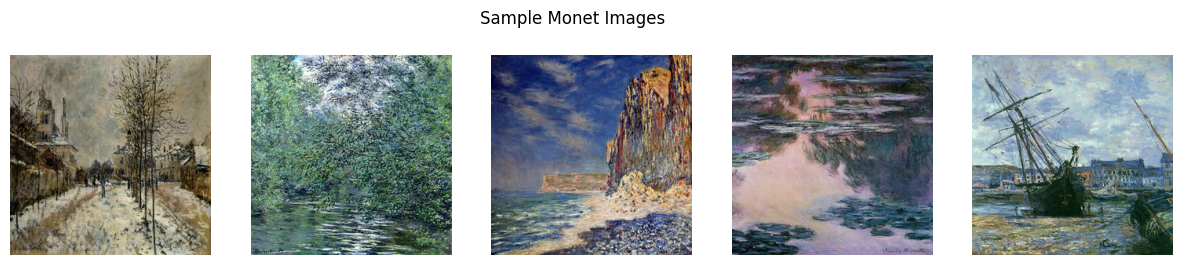

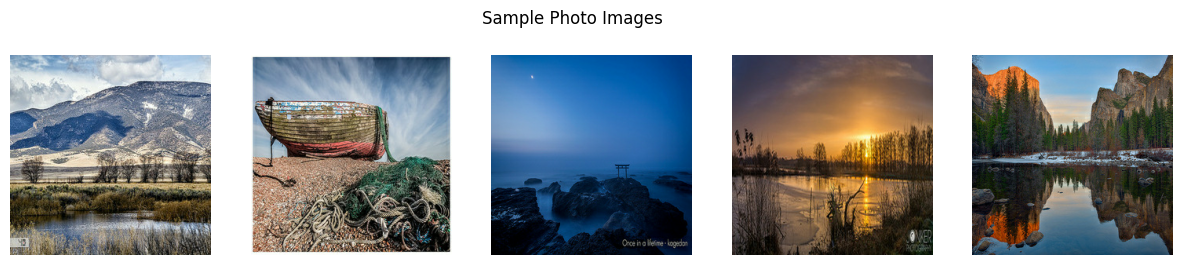

In [6]:
def show_samples(dataset, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i, image_batch in enumerate(dataset.take(1)):
        for j in range(num_images):
            image = image_batch[j]
            image = (image + 1) / 2  # Rescale to [0, 1] for display
            plt.subplot(1, num_images, j + 1)
            plt.imshow(image)
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_dataset_eda, "Sample Monet Images")
show_samples(photo_dataset_eda, "Sample Photo Images")

Ok, we have some sample images, but let's see how they differ side-by-side.

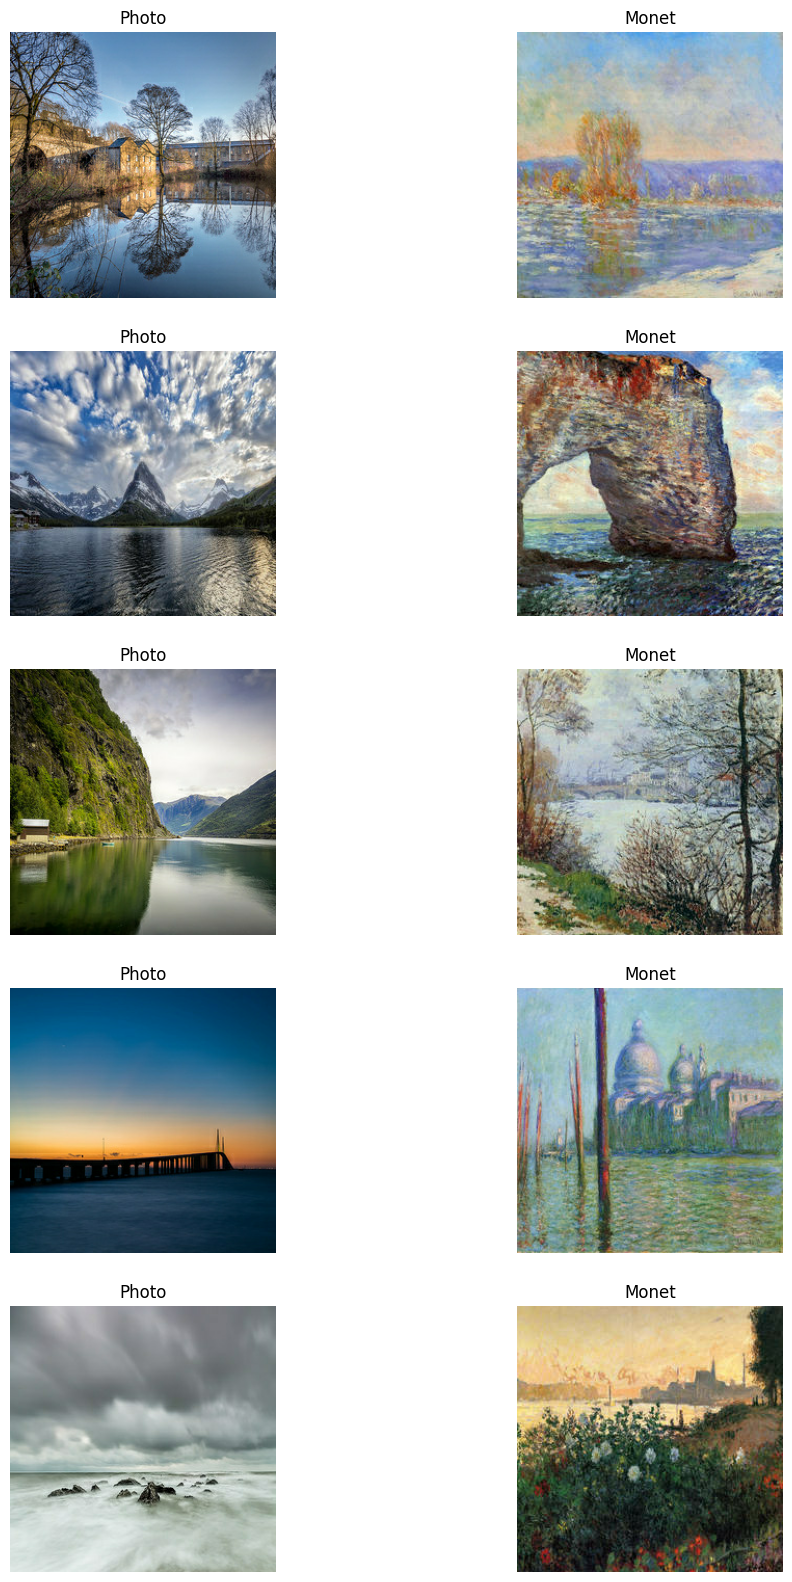

In [7]:
def show_side_by_side(photo_ds, monet_ds, n=5):
    photo_iter = iter(photo_ds.unbatch().shuffle(1000).batch(1))
    monet_iter = iter(monet_ds.unbatch().shuffle(1000).batch(1))

    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        photo = next(photo_iter)[0]
        monet = next(monet_iter)[0]
        photo = (photo + 1) / 2
        monet = (monet + 1) / 2

        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(photo)
        plt.title('Photo')
        plt.axis('off')

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(monet)
        plt.title('Monet')
        plt.axis('off')
    plt.show()

show_side_by_side(photo_dataset_eda, monet_dataset_eda)

We can see that the Monets are very different, but they also share some similar patterns. For example, the Monets have coastland, rivers, and trees. The photos also have some rivers, grass, and trees.

We want to inspect the shape of the dataset image to ensure it is as expected (i.e., batch size, 256x256, three channels).

In [8]:
for image_batch in monet_dataset_eda.take(1):
    print("Monet batch shape:", image_batch.shape)

for image_batch in photo_dataset_eda.take(1):
    print("Photo batch shape:", image_batch.shape)

Monet batch shape: (5, 256, 256, 3)
Photo batch shape: (5, 256, 256, 3)


What we want to visualize here is the difference between the monet and photo.

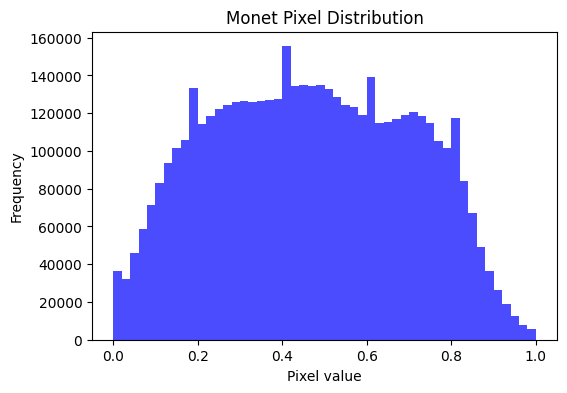

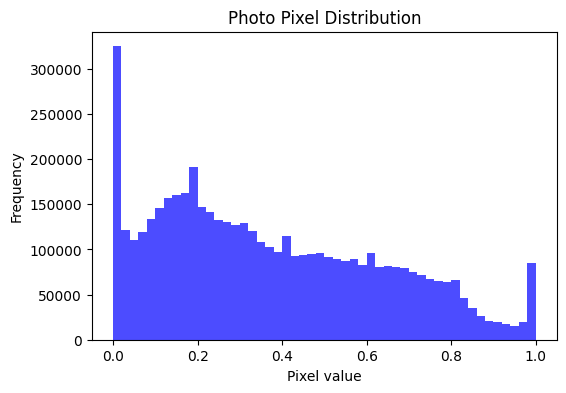

In [9]:
def plot_pixel_histogram(dataset, title):
    all_pixels = []
    for image_batch in dataset.take(5):
        images = (image_batch + 1) / 2  # Back to [0,1]
        all_pixels.extend(images.numpy().flatten())

    plt.figure(figsize=(6,4))
    plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_histogram(monet_dataset_eda, 'Monet Pixel Distribution')
plot_pixel_histogram(photo_dataset_eda, 'Photo Pixel Distribution')

We can see that the photo distribution is heavily skewed towards 0, whereas the monet distribution seems to be more normal.

Let's break that down into the three channels.

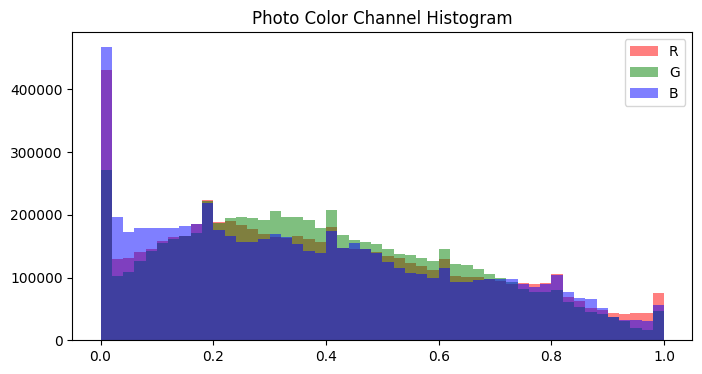

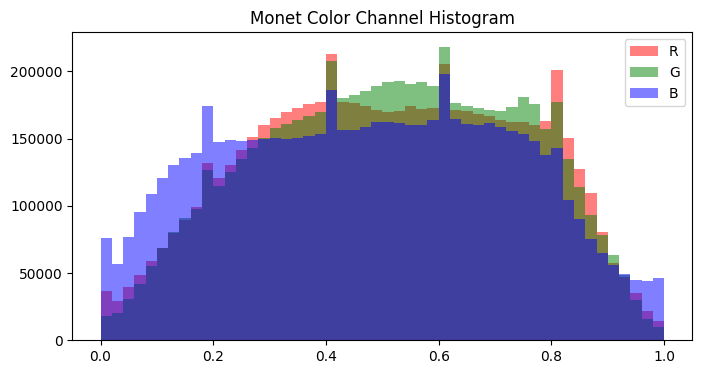

In [11]:
def plot_color_histogram(images, title):
    r, g, b = [], [], []
    for img in images.unbatch().take(100):
        img = (img + 1) / 2  # back to [0,1]
        r.extend(img[:,:,0].numpy().flatten())
        g.extend(img[:,:,1].numpy().flatten())
        b.extend(img[:,:,2].numpy().flatten())

    plt.figure(figsize=(8,4))
    plt.hist(r, bins=50, color='red', alpha=0.5, label='R')
    plt.hist(g, bins=50, color='green', alpha=0.5, label='G')
    plt.hist(b, bins=50, color='blue', alpha=0.5, label='B')
    plt.title(f'{title} Color Channel Histogram')
    plt.legend()
    plt.show()

plot_color_histogram(photo_dataset_eda, 'Photo')
plot_color_histogram(monet_dataset_eda, 'Monet')

We can see the palette shift from photo to monet. This means a GAN should be able to learn it.

What we lastly want to check for is edge detection. This will help us see how complex/detailed they are. We'll take a small sample to check the photos versus the monet.

I0000 00:00:1752210296.534037      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


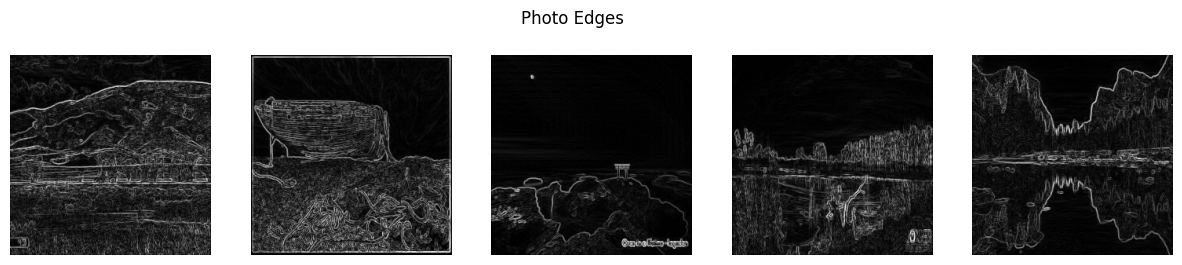

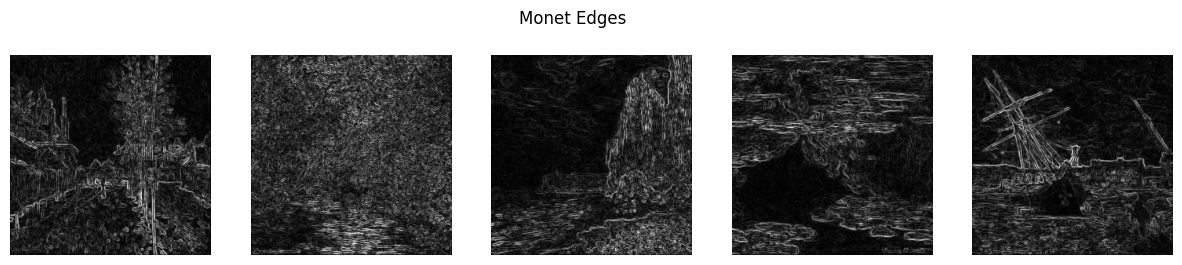

In [12]:
def show_edges(dataset, title):
    plt.figure(figsize=(15, 3))
    for i, img_batch in enumerate(dataset.take(1)):
        for j in range(5):
            img = img_batch[j]
            img = (img + 1) / 2
            img_gray = tf.image.rgb_to_grayscale(img)
            img_gray = tf.image.resize(img_gray, [256, 256])
            edges = tf.image.sobel_edges(tf.expand_dims(img_gray, axis=0))
            edges = edges[0]
            edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(edges), axis=-1))[...,0]

            plt.subplot(1, 5, j+1)
            plt.imshow(edge_magnitude, cmap='gray')
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_edges(photo_dataset_eda, 'Photo Edges')
show_edges(monet_dataset_eda, 'Monet Edges')

Examining the edges, it appears that there shouldn't be too much of a difference, which suggests that this is something our GAN can learn.

# Plan of Analysis

Based on the samples taken above, we can see there is a visual difference between photos and monet paintings. We can also see that the edges are reasonably similar, which means it shouldn't be too complex for a GAN to learn. Lastly, we can see there is a color palette difference, which is also something a GAN can learn.

Because we want to transform from one image to another without the paired data, we'll need to use Cycle GANs, which employ the generator-discriminator pattern to learn from each other.

# Preprocessing

We will load the entire dataset for training and apply augmentation (random image flipping).

In [13]:
# Imports
import tensorflow as tf
import glob


BATCH_SIZE = 1
monet_dataset_train = load_tfrecord_dataset(monet_filenames, batch_size=BATCH_SIZE, shuffle=True, augment=True)
photo_dataset_train = load_tfrecord_dataset(photo_filenames, batch_size=BATCH_SIZE, shuffle=True, augment=True)

for monet_batch in monet_dataset_train.take(1):
    print("Monet batch shape:", monet_batch.shape)

for photo_batch in photo_dataset_train.take(1):
    print("Photo batch shape:", photo_batch.shape)


Monet batch shape: (1, 256, 256, 3)
Photo batch shape: (1, 256, 256, 3)


# Model Architecture

We are following Jang's (2020) tutorial, and she is creating a cycle GAN. It has been slightly modified to make it easier to follow.

## Generator

We're building the generator using downsampling and the encoder to extract features. We then use Residual Blocks to learn the residual functions (transforming the features) and finally upsampling with the decoder. Since our images are in the range of -1 to 1, we can use the tanh function as the final output function for the pixel.

We will create a generator that can transform a photo into a Monet-style image and vice versa.

In [14]:
from tensorflow.keras import layers

def resnet_block(x, filters):
    y = layers.Conv2D(filters, (3, 3), padding='same')(x)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters, (3, 3), padding='same')(y)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)
    return layers.add([x, y])

def build_generator(image_shape=(256, 256, 3), n_res_blocks=9):
    inputs = layers.Input(shape=image_shape)

    # Encoder
    x = layers.Conv2D(64, (7, 7), padding='same')(inputs)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    # ResNet Blocks
    for _ in range(n_res_blocks):
        x = resnet_block(x, 256)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)

## Discriminator

The discriminator has to classify whether the image is real or fake. In this case, we are using a PatchGAN design, a common approach for CycleGANs. This will help the discriminator focus on the features of the image, such as brushstrokes. 

In [15]:
def build_discriminator(image_shape=(256, 256, 3)):
    inputs = layers.Input(shape=image_shape)

    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, (4, 4), strides=1, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, (4, 4), strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x)


Now is the time to build the model. With CycleGAN, we need to cycle through the generators and discriminators.

In [16]:
generator_pm = build_generator()  # Photo → Monet
generator_mp = build_generator()  # Monet → Photo

discriminator_p = build_discriminator()  # Discriminates Photos
discriminator_m = build_discriminator()  # Discriminates Monet

## Loss Functions

Now, we will define the loss functions and constants.

* Adversarial loss: Loss function for trying to make fake look authentic.
* Discriminator loss: Loss function for trying to determine what is fake vs. real.
* Cycle-consistency loss: Ensuring that the round-trip looks like the original.
* Identity loss: Don't change images already in the target style.

We also use the suggested Adam optimizers for CycleGAN.

In [17]:
import tensorflow as tf

# ✅ Constants for weighting
LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0

# ✅ Binary Crossentropy for real vs. fake
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# ✅ Adversarial Loss (Generator wants Discriminator to say 'real')
def generator_adversarial_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

# ✅ Discriminator Loss (real should be 1, fake should be 0)
def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

# ✅ Cycle-consistency Loss
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss

# ✅ Identity Loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_ID * loss

# ✅ Optimizers (standard Adam settings for CycleGAN)
generator_pm_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_mp_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We want to add some checkpointing, so that we can restore the weights later if we interrupt the training and need to come back.

In [18]:
# 1. Define Checkpoint
ckpt = tf.train.Checkpoint(generator_pm=generator_pm,
                           generator_mp=generator_mp,
                           discriminator_p=discriminator_p,
                           discriminator_m=discriminator_m,
                           generator_pm_optimizer=generator_pm_optimizer,
                           generator_mp_optimizer=generator_mp_optimizer,
                           discriminator_p_optimizer=discriminator_p_optimizer,
                           discriminator_m_optimizer=discriminator_m_optimizer)

# 2. Define Manager
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=5)

# 3. Restore if available
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restored from {ckpt_manager.latest_checkpoint}")
else:
    print("Starting training from scratch.")

Starting training from scratch.


# Results and Analysis

In this section, we will run the models and begin optimizing against them. For this project, only one model type is available (Cycle GAN), as explained above.

## V1. Starting Model

Now that we have the model architecture in place, let's begin training.

In [19]:
@tf.function
def train_step(real_p, real_m):
    with tf.GradientTape(persistent=True) as tape:
        # --------------------------------
        # Generator_PM: Photo -> Monet
        # --------------------------------
        fake_m = generator_pm(real_p, training=True)
        cycled_p = generator_mp(fake_m, training=True)

        # --------------------------------
        # Generator_MP: Monet -> Photo
        # --------------------------------
        fake_p = generator_mp(real_m, training=True)
        cycled_m = generator_pm(fake_p, training=True)

        # --------------------------------
        # Identity Mapping
        # --------------------------------
        same_p = generator_mp(real_p, training=True)
        same_m = generator_pm(real_m, training=True)

        # --------------------------------
        # Discriminator Outputs
        # --------------------------------
        disc_real_p = discriminator_p(real_p, training=True)
        disc_real_m = discriminator_m(real_m, training=True)
        disc_fake_p = discriminator_p(fake_p, training=True)
        disc_fake_m = discriminator_m(fake_m, training=True)

        # --------------------------------
        # Generator Losses
        # --------------------------------
        gen_pm_loss = generator_adversarial_loss(disc_fake_m)
        gen_mp_loss = generator_adversarial_loss(disc_fake_p)

        total_cycle_loss = calc_cycle_loss(real_p, cycled_p) + calc_cycle_loss(real_m, cycled_m)

        total_gen_pm_loss = gen_pm_loss + total_cycle_loss + identity_loss(real_m, same_m)
        total_gen_mp_loss = gen_mp_loss + total_cycle_loss + identity_loss(real_p, same_p)

        # --------------------------------
        # Discriminator Losses
        # --------------------------------
        disc_p_loss = discriminator_loss(disc_real_p, disc_fake_p)
        disc_m_loss = discriminator_loss(disc_real_m, disc_fake_m)

    # --------------------------------
    # Calculate and Apply Gradients
    # --------------------------------
    generator_pm_gradients = tape.gradient(total_gen_pm_loss, generator_pm.trainable_variables)
    generator_mp_gradients = tape.gradient(total_gen_mp_loss, generator_mp.trainable_variables)

    discriminator_p_gradients = tape.gradient(disc_p_loss, discriminator_p.trainable_variables)
    discriminator_m_gradients = tape.gradient(disc_m_loss, discriminator_m.trainable_variables)

    generator_pm_optimizer.apply_gradients(zip(generator_pm_gradients, generator_pm.trainable_variables))
    generator_mp_optimizer.apply_gradients(zip(generator_mp_gradients, generator_mp.trainable_variables))

    discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients, discriminator_p.trainable_variables))
    discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients, discriminator_m.trainable_variables))

    return {
        'gen_pm_loss': total_gen_pm_loss,
        'gen_mp_loss': total_gen_mp_loss,
        'disc_p_loss': disc_p_loss,
        'disc_m_loss': disc_m_loss
    }

In [21]:
import time

def train(dataset_P, dataset_M, epochs=1):
    history = {
        'gen_pm_loss': [],
        'gen_mp_loss': [],
        'disc_p_loss': [],
        'disc_m_loss': []
    }
    
    for epoch in range(epochs):
        start = time.time()
        print(f"Epoch {epoch+1}/{epochs}")
        
        gen_pm_losses = []
        gen_mp_losses = []
        disc_p_losses = []
        disc_m_losses = []
        
        for real_p, real_m in tf.data.Dataset.zip((dataset_P, dataset_M)):
            losses = train_step(real_p, real_m)
            gen_pm_losses.append(losses['gen_pm_loss'].numpy())
            gen_mp_losses.append(losses['gen_mp_loss'].numpy())
            disc_p_losses.append(losses['disc_p_loss'].numpy())
            disc_m_losses.append(losses['disc_m_loss'].numpy())
        
        # Average for the epoch
        history['gen_pm_loss'].append(np.mean(gen_pm_losses))
        history['gen_mp_loss'].append(np.mean(gen_mp_losses))
        history['disc_p_loss'].append(np.mean(disc_p_losses))
        history['disc_m_loss'].append(np.mean(disc_m_losses))
        
        print(f"Time for epoch {epoch+1}: {time.time() - start:.2f} sec")
        print(f"Gen_PM Loss: {history['gen_pm_loss'][-1]:.4f} | Gen_MP Loss: {history['gen_mp_loss'][-1]:.4f}")
        print(f"Disc_P Loss: {history['disc_p_loss'][-1]:.4f} | Disc_M Loss: {history['disc_m_loss'][-1]:.4f}\n")
        
        ckpt_save_path = ckpt_manager.save()
        print(f"✅ Checkpoint saved at {ckpt_save_path}\n")
    
    return history

In [22]:
history = train(photo_dataset_train, monet_dataset_train, epochs=10)

Epoch 1/10
Time for epoch 1: 214.00 sec
Gen_PM Loss: 8.4813 | Gen_MP Loss: 8.2848
Disc_P Loss: 0.6773 | Disc_M Loss: 0.7004

✅ Checkpoint saved at ./checkpoints/ckpt-1

Epoch 2/10
Time for epoch 2: 133.58 sec
Gen_PM Loss: 6.9553 | Gen_MP Loss: 7.0280
Disc_P Loss: 0.6274 | Disc_M Loss: 0.6444

✅ Checkpoint saved at ./checkpoints/ckpt-2

Epoch 3/10
Time for epoch 3: 133.24 sec
Gen_PM Loss: 6.7054 | Gen_MP Loss: 6.7454
Disc_P Loss: 0.6053 | Disc_M Loss: 0.6362

✅ Checkpoint saved at ./checkpoints/ckpt-3

Epoch 4/10
Time for epoch 4: 133.51 sec
Gen_PM Loss: 6.2598 | Gen_MP Loss: 6.1137
Disc_P Loss: 0.6474 | Disc_M Loss: 0.6403

✅ Checkpoint saved at ./checkpoints/ckpt-4

Epoch 5/10
Time for epoch 5: 133.16 sec
Gen_PM Loss: 5.3728 | Gen_MP Loss: 5.1493
Disc_P Loss: 0.6601 | Disc_M Loss: 0.6310

✅ Checkpoint saved at ./checkpoints/ckpt-5

Epoch 6/10
Time for epoch 6: 133.19 sec
Gen_PM Loss: 5.5794 | Gen_MP Loss: 5.2010
Disc_P Loss: 0.6351 | Disc_M Loss: 0.5744

✅ Checkpoint saved at ./checkp

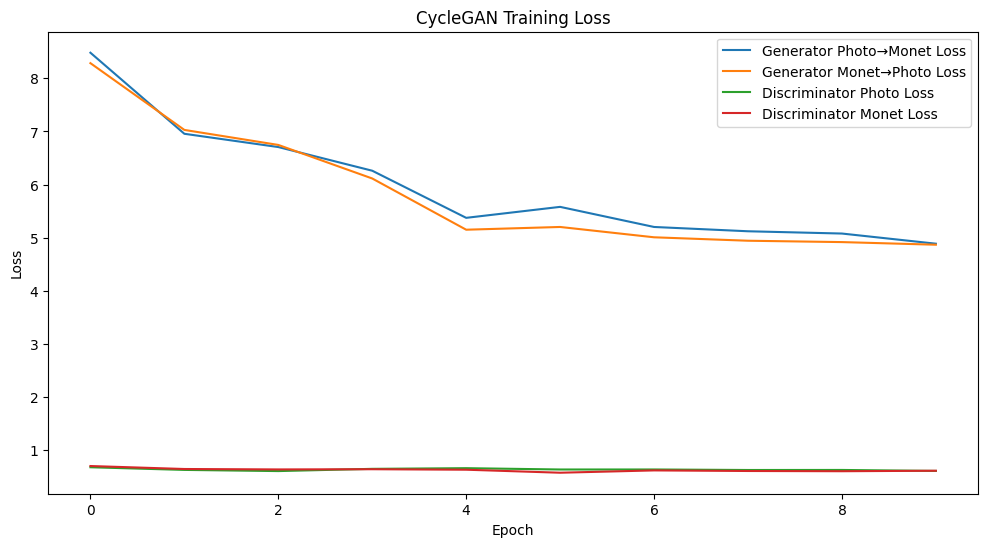

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history['gen_pm_loss'], label='Generator Photo→Monet Loss')
plt.plot(history['gen_mp_loss'], label='Generator Monet→Photo Loss')
plt.plot(history['disc_p_loss'], label='Discriminator Photo Loss')
plt.plot(history['disc_m_loss'], label='Discriminator Monet Loss')
plt.title('CycleGAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now let's run the image generation.

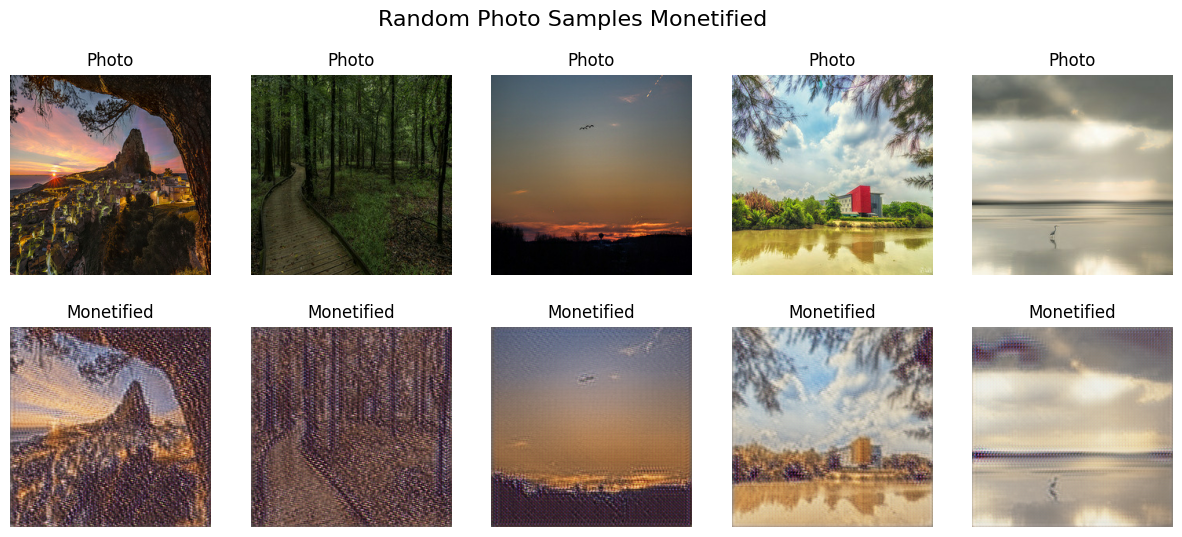

In [24]:
import random
import matplotlib.pyplot as plt

# Define denormalization helper
def denormalize_image(image):
    image = (image + 1) * 127.5
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

# Take 5 random photos from training dataset
photo_batches = list(photo_dataset_train)
random.shuffle(photo_batches)
photo_samples = [batch[0] for batch in photo_batches[:5]]

# Monetify
monetified_samples = []
for photo in photo_samples:
    monetified = generator_pm(tf.expand_dims(photo, 0), training=False)[0]
    monetified_samples.append(denormalize_image(monetified).numpy())

# Plot
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(denormalize_image(photo_samples[i]).numpy())
    plt.title('Photo')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(monetified_samples[i])
    plt.title('Monetified')
    plt.axis('off')

plt.suptitle('Random Photo Samples Monetified', fontsize=16)
plt.show()


In [ ]:
# import os
# from PIL import Image
# import numpy as np

# output_dir = '/kaggle/working/generated_images_model_v1'
# os.makedirs(output_dir, exist_ok=True)

# index = 0

# for photo_batch in photo_dataset_train:
#     generated_batch = generator_pm(photo_batch, training=False)
    
#     # Process each image in the batch (in case batch_size > 1)
#     for i in range(generated_batch.shape[0]):
#         generated = denormalize_image(generated_batch[i]).numpy()
#         img = Image.fromarray(generated)
#         img.convert('RGB').save(os.path.join(output_dir, f'{index}.jpg'), 'JPEG')
#         index += 1

# print(f"✅ Saved {index} generated Monet-style images to: {output_dir}")

# import zipfile

# submission_zip = '/kaggle/working/images.zip'

# with zipfile.ZipFile(submission_zip, 'w') as zipf:
#     for i in range(index):
#         zipf.write(os.path.join(output_dir, f'{i}.jpg'), arcname=f'{i}.jpg')

# print(f"✅ Created images zip: {submission_zip}")

The first version of the model got a score of 87.63909. What we need to do now is optimize the model to see how we can improve it.

## V2. Use More Data Augmentation

Currently, the only thing we do is flip the images. What I will add is changing the brightness and the contrast.

In [25]:
# 1. Define Checkpoint
ckpt = tf.train.Checkpoint(generator_pm=generator_pm,
                           generator_mp=generator_mp,
                           discriminator_p=discriminator_p,
                           discriminator_m=discriminator_m,
                           generator_pm_optimizer=generator_pm_optimizer,
                           generator_mp_optimizer=generator_mp_optimizer,
                           discriminator_p_optimizer=discriminator_p_optimizer,
                           discriminator_m_optimizer=discriminator_m_optimizer)

# 2. Define Manager
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints_v2', max_to_keep=5)

# 3. Restore if available
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restored from {ckpt_manager.latest_checkpoint}")
else:
    print("Starting training from scratch.")

Starting training from scratch.


In [26]:
def parse_tfrecord_v2(example, image_size=(256, 256), augment=False):
    features = {'image': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, image_size)
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    
    return image

def load_tfrecord_dataset_v2(filenames, batch_size=1, shuffle=False, buffer_size=2048, image_size=(256, 256), augment=False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x: parse_tfrecord_v2(x, image_size=image_size, augment=augment),
                          num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Imports
import tensorflow as tf
import glob


BATCH_SIZE = 1
monet_dataset_train_v2 = load_tfrecord_dataset_v2(monet_filenames, batch_size=BATCH_SIZE, shuffle=True, augment=True)
photo_dataset_train_v2 = load_tfrecord_dataset_v2(photo_filenames, batch_size=BATCH_SIZE, shuffle=True, augment=True)

history_v2 = train(photo_dataset_train_v2, monet_dataset_train_v2, epochs=10)

Epoch 1/10
Time for epoch 1: 133.18 sec
Gen_PM Loss: 4.8143 | Gen_MP Loss: 4.8076
Disc_P Loss: 0.6418 | Disc_M Loss: 0.6381

✅ Checkpoint saved at ./checkpoints_v2/ckpt-1

Epoch 2/10
Time for epoch 2: 133.27 sec
Gen_PM Loss: 4.7979 | Gen_MP Loss: 4.7010
Disc_P Loss: 0.6171 | Disc_M Loss: 0.5974

✅ Checkpoint saved at ./checkpoints_v2/ckpt-2

Epoch 3/10
Time for epoch 3: 133.05 sec
Gen_PM Loss: 4.6674 | Gen_MP Loss: 4.5861
Disc_P Loss: 0.6359 | Disc_M Loss: 0.6166

✅ Checkpoint saved at ./checkpoints_v2/ckpt-3

Epoch 4/10
Time for epoch 4: 132.96 sec
Gen_PM Loss: 4.6473 | Gen_MP Loss: 4.5605
Disc_P Loss: 0.6373 | Disc_M Loss: 0.6191

✅ Checkpoint saved at ./checkpoints_v2/ckpt-4

Epoch 5/10
Time for epoch 5: 132.98 sec
Gen_PM Loss: 4.6994 | Gen_MP Loss: 4.6621
Disc_P Loss: 0.6206 | Disc_M Loss: 0.6128

✅ Checkpoint saved at ./checkpoints_v2/ckpt-5

Epoch 6/10
Time for epoch 6: 132.81 sec
Gen_PM Loss: 4.5532 | Gen_MP Loss: 4.5050
Disc_P Loss: 0.6345 | Disc_M Loss: 0.6228

✅ Checkpoint sa

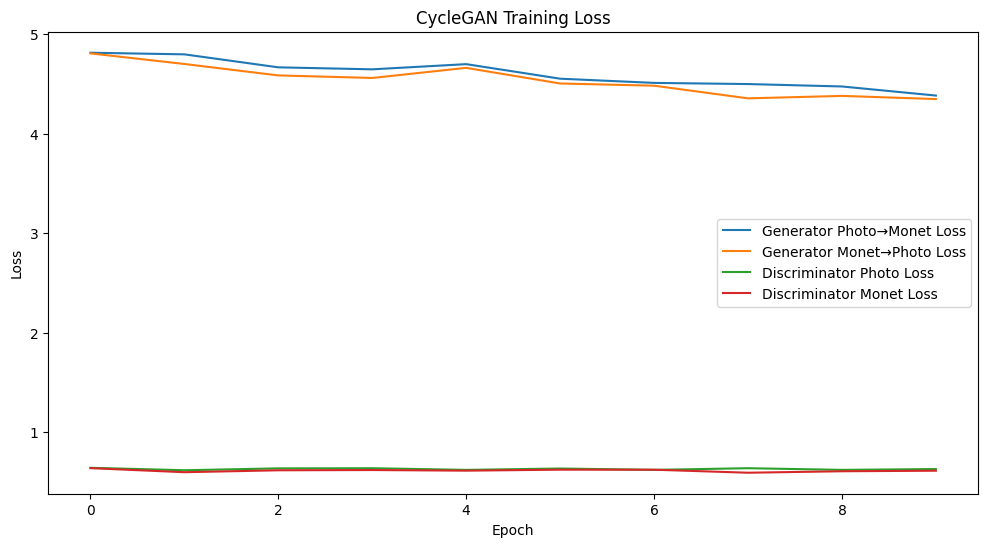

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history_v2['gen_pm_loss'], label='Generator Photo→Monet Loss')
plt.plot(history_v2['gen_mp_loss'], label='Generator Monet→Photo Loss')
plt.plot(history_v2['disc_p_loss'], label='Discriminator Photo Loss')
plt.plot(history_v2['disc_m_loss'], label='Discriminator Monet Loss')
plt.title('CycleGAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see from the history above that the loss does decrease over time; however, how will it perform when we generate images and obtain the MFID score?

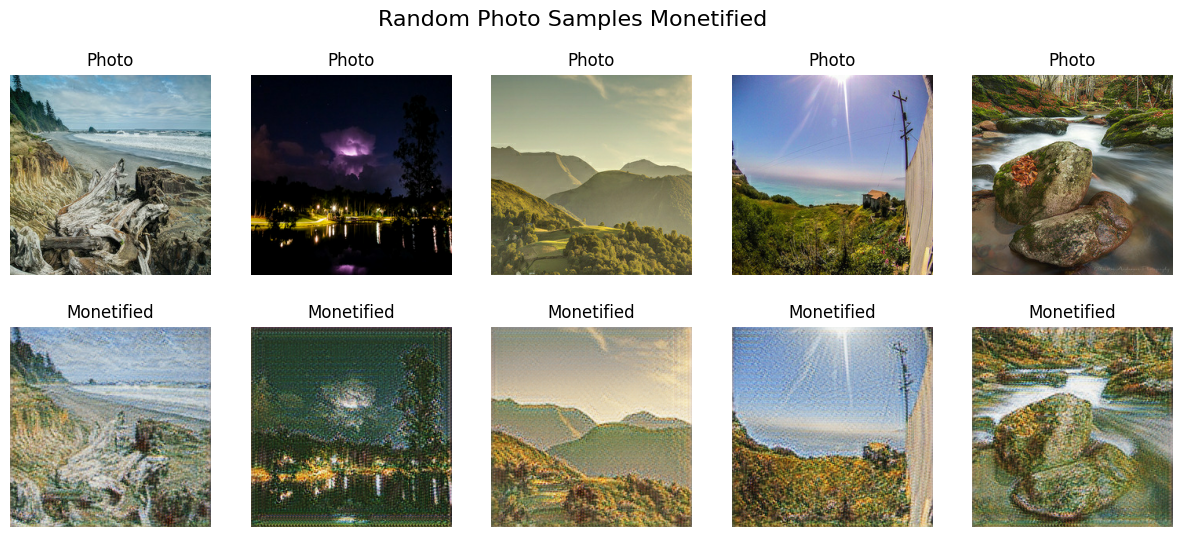

In [29]:
import random
import matplotlib.pyplot as plt

# Define denormalization helper
def denormalize_image(image):
    image = (image + 1) * 127.5
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

# Take 5 random photos from training dataset
photo_batches = list(photo_dataset_train_v2)
random.shuffle(photo_batches)
photo_samples = [batch[0] for batch in photo_batches[:5]]

# Monetify
monetified_samples = []
for photo in photo_samples:
    monetified = generator_pm(tf.expand_dims(photo, 0), training=False)[0]
    monetified_samples.append(denormalize_image(monetified).numpy())

# Plot
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(denormalize_image(photo_samples[i]).numpy())
    plt.title('Photo')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(monetified_samples[i])
    plt.title('Monetified')
    plt.axis('off')

plt.suptitle('Random Photo Samples Monetified', fontsize=16)
plt.show()

In [ ]:
# import os
# from PIL import Image
# import numpy as np

# output_dir = '/kaggle/working/generated_images_model_v2'
# os.makedirs(output_dir, exist_ok=True)

# index = 0

# for photo_batch in photo_dataset_train:
#     generated_batch = generator_pm(photo_batch, training=False)
    
#     # Process each image in the batch (in case batch_size > 1)
#     for i in range(generated_batch.shape[0]):
#         generated = denormalize_image(generated_batch[i]).numpy()
#         img = Image.fromarray(generated)
#         img.convert('RGB').save(os.path.join(output_dir, f'{index}.jpg'), 'JPEG')
#         index += 1

# print(f"✅ Saved {index} generated Monet-style images to: {output_dir}")

# import zipfile

# submission_zip = '/kaggle/working/images.zip'

# with zipfile.ZipFile(submission_zip, 'w') as zipf:
#     for i in range(index):
#         zipf.write(os.path.join(output_dir, f'{i}.jpg'), arcname=f'{i}.jpg')

# print(f"✅ Created images zip: {submission_zip}")

Score: 99.56088. This performed worse than my initial version. 

## V3. Increase Epochs and Change Lambda Loss Weights

I want to perform one last optimization, which involves adjusting the LAMBDA_CYCLE and LAMBDA_ID weights. These are hyperparameters to the CycleGAN loss function. I will also increase the number of epochs from 10 to 20.

In [30]:
# 1. Define Checkpoint
ckpt = tf.train.Checkpoint(generator_pm=generator_pm,
                           generator_mp=generator_mp,
                           discriminator_p=discriminator_p,
                           discriminator_m=discriminator_m,
                           generator_pm_optimizer=generator_pm_optimizer,
                           generator_mp_optimizer=generator_mp_optimizer,
                           discriminator_p_optimizer=discriminator_p_optimizer,
                           discriminator_m_optimizer=discriminator_m_optimizer)

# 2. Define Manager
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints_v3', max_to_keep=5)

# 3. Restore if available
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Restored from {ckpt_manager.latest_checkpoint}")
else:
    print("Starting training from scratch.")

Starting training from scratch.


In [31]:
# Imports
import tensorflow as tf
import glob


BATCH_SIZE = 1
LAMBDA_CYCLE = 15.0
LAMBDA_ID = 8.0

history_v3 = train(photo_dataset_train, monet_dataset_train, epochs=20)

Epoch 1/20
Time for epoch 1: 132.88 sec
Gen_PM Loss: 4.2219 | Gen_MP Loss: 4.1619
Disc_P Loss: 0.6339 | Disc_M Loss: 0.6191

✅ Checkpoint saved at ./checkpoints_v3/ckpt-1

Epoch 2/20
Time for epoch 2: 132.95 sec
Gen_PM Loss: 4.0721 | Gen_MP Loss: 4.0043
Disc_P Loss: 0.6340 | Disc_M Loss: 0.6226

✅ Checkpoint saved at ./checkpoints_v3/ckpt-2

Epoch 3/20
Time for epoch 3: 132.94 sec
Gen_PM Loss: 4.1570 | Gen_MP Loss: 4.0842
Disc_P Loss: 0.6302 | Disc_M Loss: 0.6116

✅ Checkpoint saved at ./checkpoints_v3/ckpt-3

Epoch 4/20
Time for epoch 4: 132.81 sec
Gen_PM Loss: 4.0565 | Gen_MP Loss: 3.9739
Disc_P Loss: 0.6325 | Disc_M Loss: 0.6126

✅ Checkpoint saved at ./checkpoints_v3/ckpt-4

Epoch 5/20
Time for epoch 5: 132.63 sec
Gen_PM Loss: 3.9714 | Gen_MP Loss: 3.9105
Disc_P Loss: 0.6406 | Disc_M Loss: 0.6276

✅ Checkpoint saved at ./checkpoints_v3/ckpt-5

Epoch 6/20
Time for epoch 6: 132.41 sec
Gen_PM Loss: 3.9493 | Gen_MP Loss: 3.9135
Disc_P Loss: 0.6311 | Disc_M Loss: 0.6217

✅ Checkpoint sa

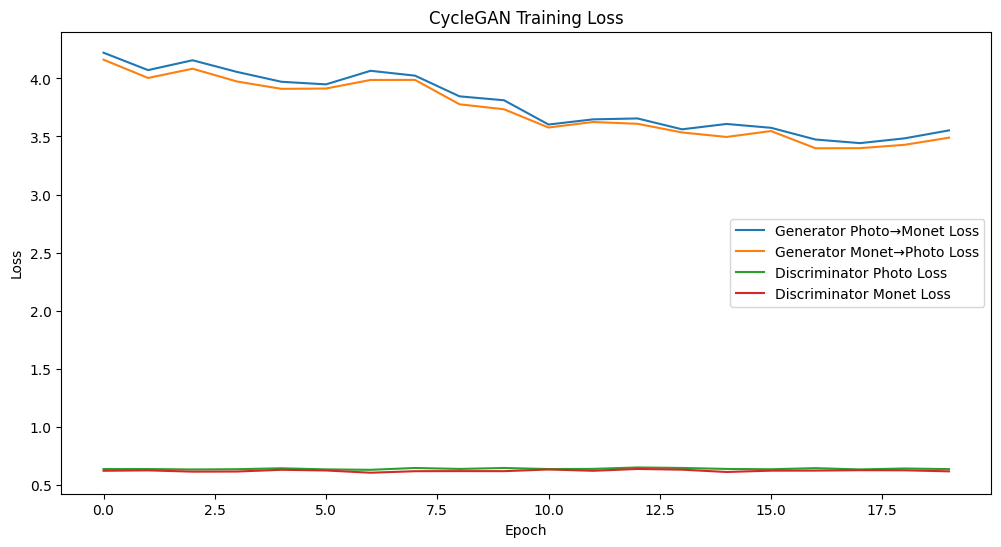

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history_v3['gen_pm_loss'], label='Generator Photo→Monet Loss')
plt.plot(history_v3['gen_mp_loss'], label='Generator Monet→Photo Loss')
plt.plot(history_v3['disc_p_loss'], label='Discriminator Photo Loss')
plt.plot(history_v3['disc_m_loss'], label='Discriminator Monet Loss')
plt.title('CycleGAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see from the history graph above that the generator loss for both the photo-to-monet and monet-to-photo decreases over time. So, to improve, we would likely need to continue with longer epochs.

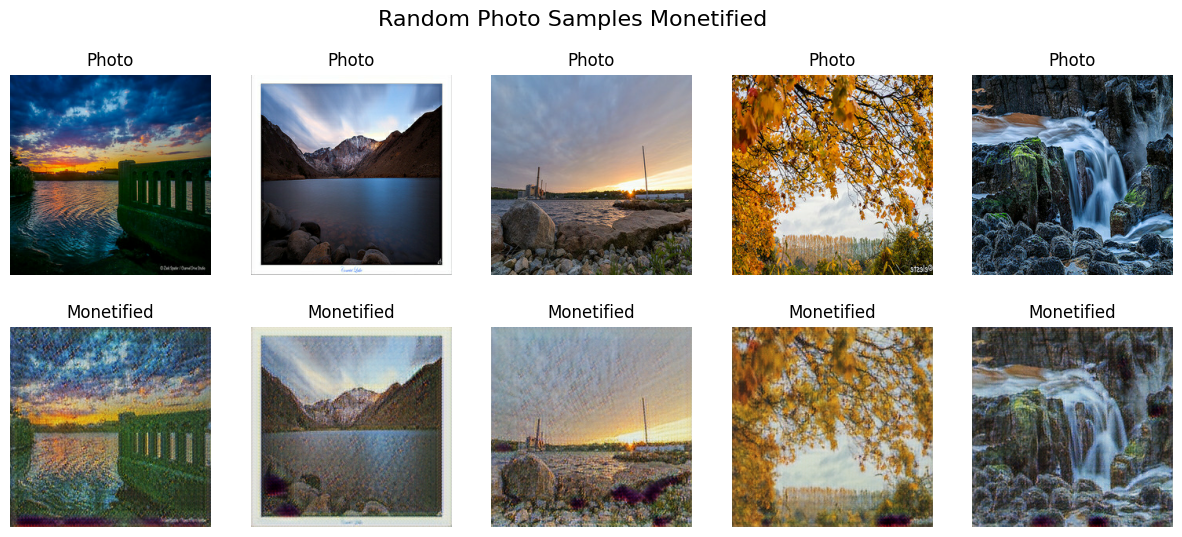

In [33]:
import random
import matplotlib.pyplot as plt

# Define denormalization helper
def denormalize_image(image):
    image = (image + 1) * 127.5
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

# Take 5 random photos from training dataset
photo_batches = list(photo_dataset_train)
random.shuffle(photo_batches)
photo_samples = [batch[0] for batch in photo_batches[:5]]

# Monetify
monetified_samples = []
for photo in photo_samples:
    monetified = generator_pm(tf.expand_dims(photo, 0), training=False)[0]
    monetified_samples.append(denormalize_image(monetified).numpy())

# Plot
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(denormalize_image(photo_samples[i]).numpy())
    plt.title('Photo')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(monetified_samples[i])
    plt.title('Monetified')
    plt.axis('off')

plt.suptitle('Random Photo Samples Monetified', fontsize=16)
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np

output_dir = '/kaggle/working/generated_images_model_v3'
os.makedirs(output_dir, exist_ok=True)

index = 0

for photo_batch in photo_dataset_train:
    generated_batch = generator_pm(photo_batch, training=False)
    
    # Process each image in the batch (in case batch_size > 1)
    for i in range(generated_batch.shape[0]):
        generated = denormalize_image(generated_batch[i]).numpy()
        img = Image.fromarray(generated)
        img.convert('RGB').save(os.path.join(output_dir, f'{index}.jpg'), 'JPEG')
        index += 1

print(f"✅ Saved {index} generated Monet-style images to: {output_dir}")

import zipfile

submission_zip = '/kaggle/working/images.zip'

with zipfile.ZipFile(submission_zip, 'w') as zipf:
    for i in range(index):
        zipf.write(os.path.join(output_dir, f'{i}.jpg'), arcname=f'{i}.jpg')

print(f"✅ Created images zip: {submission_zip}")

Score: 84.07554. This performed better than V1 (lower score).

# Conclusion and Learning

In [2]:
import pandas as pd

results = {
    'Model': ['Cycle GAN', 'Cycle GAN with More Augmentation', 'Cycle GAN with More Epochs and Lamda Loss Change'],
    'MFID': [87.63909, 99.56088, 84.07554],
}

df_result = pd.DataFrame(results).sort_values(by=['MFID'], ascending=True)
df_result

Model      MFID
2  Cycle GAN with More Epochs and Lamda Loss Change  84.07554
0                                         Cycle GAN  87.63909
1                  Cycle GAN with More Augmentation  99.56088

From the table above, we can see that CycleGAN with increased Epochs has resulted in the best score. The original CycleGAN performed in the middle, and the CycleGAN with additional augmentation performed the worst.

We observed, after running the actual generation and obtaining the MFID score, that the additional augmentation did not provide any benefit and performed significantly worse. My assumption here is that adding the additional randomness made it harder for the GAN to match the target distribution. It had trouble matching domains.

What I've learned is that for CycleGAN, the number of Epochs is significant. To improve the algorithm further, we can:

* Add additional Epochs.
* Try adding dropout to the discriminator.
* Use a learning rate scheduler.

## Conclusion

Overall, the Kaggle ranking is pretty good. However, it would be better to be in the lower 30s. That means that this model still has a long way to go. What we observed was that CycleGAN with additional augmentation performed the worst, likely because the two distributions would have been more complex to match within the given number of Epochs. Version three, with increased Epochs, performed the best.

Note: This is a helper function for deleting checkpoints. I used this to ensure we restart the entire Kaggle working space.

In [ ]:
#import shutil

#folders_to_delete = ['./checkpoints', './checkpoints_v2']

#for folder in folders_to_delete:
#    shutil.rmtree(folder, ignore_errors=True)
#    print(f"✅ Deleted checkpoint folder: {folder}")

# References

Jang, A., Uzsoy, A., S., & Culliton, P. (2020). I’m Something of a Painter Myself. Retrieved 05/13/2025 from https://kaggle.com/competitions/gan-getting-started

Jang, A. (2020). Monet CycleGAN Tutorial.  Retrieved 05/13/2025 from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial